# Introduction

This notebook is a series of experiments with exploring Linkedin job. The jobs were downloaded directly from Linkedin
with the filters: Machine Learning Engineer +London, Data Scientist + London, Senior Data Scintist + London.
Clearly, all these jobs are meant for me &#128512;.
The techniques I use in this notebook are a combination of supervised, unsupervised and Transfer learning.
This notebook comes with the little Fastapi app that I developed to showcase the use of several endpoints.

The limitations are:
- My annotations were quick and dirty and focused on NLP roles.
- Some of the tools are only used in hight level, and could be advanced and improved.
- I use my personal CV here and my personal job prefernces. 


Table of contents:

- Data Loading
- Bert topic, to see what the Job decsriptions are about
- NER
    - NER with spacy
- Write cover letter given my CV and JD
- Classification of submit/not submit
    - Zero Shot Classification
    - sklearn classifier
    - same features but with a neural network
- Question answering with my Data
    - cohere retriever

# Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import re
from nltk import word_tokenize
from tqdm import tqdm
import json

In [2]:
#so I can import the libraries
sys.path.append('/Users/yuliagoryachev/job-search-enhanced/app/')

In [3]:
from utils.data_loader import Loader

The data I load here is the raw downloaded data, namely a collection of csv files downloaded with the “jobs scraper extension” https://chromewebstore.google.com/detail/jobs-scraper-for-linkedin/jhmlphenakpfjkieogpinommlgjdjnhb. It also has few job descriprion files standalone that I doenloaded previously and my CV.
The raw data downloaded with the Linkedin extension has few extrac columns buil in like company name, url to likedin post, etc.

In [4]:
data_path ='/Users/yuliagoryachev/learning/langchain_course/llms/data/'

In [5]:
loader = Loader(data_path)

In [6]:
csv_data = loader.load_csv()

In [57]:
loader.files

['/Users/yuliagoryachev/learning/langchain_course/llms/data/ml_eng_20_jobs_2024-02-03_2.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/ml_eng_20_jobs_2024-02-03_3.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/ml_eng_20_jobs_2024-02-03_1.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/ml_eng_20_jobs_2024-02-03_4.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/ml_eng_20_jobs_2024-02-03_5.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/ml-eng_20_jobs_2024-02-03_0.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/data_scientist_20_jobs_2024-02-03_5.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/data_scientist_20_jobs_2024-02-03_4.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/data_scientist_20_jobs_2024-02-03_3.csv',
 '/Users/yuliagoryachev/learning/langchain_course/llms/data/data_scientist_20_jobs_2024-02-03_2.csv',
 '/Users/yuliagoryachev/lear

In [24]:
csv_data.shape

(199, 18)

In [26]:
keep_columns = ['Title', 'Description',	'Description HTML',	'Primary Description', 'Detail URL', 'Location', 'Skill',	
                'Insight', 'Job State', 'Poster Id', 'Company Name', 'Company Logo', 'Created At',	'Scraped At']

In [27]:
csv_data[keep_columns].head()

,Title,Description,Description HTML,Primary Description,Detail URL,Location,Skill,Insight,Job State,Poster Id,Company Name,Company Logo,Created At,Scraped At
0,Senior Machine Learning Engineer,"We’re Kingfisher, A team made up of over 82,00...","We’re Kingfisher, A team made up of over 82,00...",Kingfisher plc,https://www.linkedin.com/jobs/view/3814449890/,"London, England, United Kingdom","Skills: Data Science, Algorithms, +8 more","10,001+ employees · Retail\n5 school alumni wo...",LISTED,355743591,Kingfisher plc,https://media.licdn.com/dms/image/D4E0BAQEE--Y...,2024-01-26T20:07:02.000Z,2024-02-03T21:37:33.491Z
1,Senior Machine Learning Engineer,Onfido lets people prove their identity anytim...,Onfido lets people prove their identity anytim...,Onfido,https://www.linkedin.com/jobs/view/3765912230/,United Kingdom,NaN,"501-1,000 employees · IT Services and IT Consu...",LISTED,503392794,Onfido,https://media.licdn.com/dms/image/D560BAQGTOTw...,2023-11-15T14:47:42.000Z,2024-02-03T21:37:33.491Z
2,"Staff ML Engineer, Large Language Models",The companyNebius AI is an AI-centric public c...,<p><strong>The company</strong></p><p>Nebius A...,Nebius,https://www.linkedin.com/jobs/view/3806452598/,"London, England, United Kingdom",8 of 10 skills match your profile - you may be...,201-500 employees · IT Services and IT Consulting,LISTED,866898496,Nebius,https://media.licdn.com/dms/image/D4E0BAQGHUEX...,2024-01-19T15:43:46.000Z,2024-02-03T21:37:33.491Z
3,Applied AI ML Lead - Senior Machine Learning E...,Job Description\n\nApplied AI ML at JPMorgan C...,<strong>Job Description\n\n</strong>Applied AI...,JPMorgan Chase & Co.,https://www.linkedin.com/jobs/view/3812092884/,"London, England, United Kingdom",6 of 10 skills match your profile - you may be...,"10,001+ employees · Financial Services\n1 comp...",LISTED,6077559,JPMorgan Chase & Co.,https://media.licdn.com/dms/image/C4E0BAQFN7ZG...,2024-01-27T04:12:14.000Z,2024-02-03T21:37:33.491Z
4,Machine Learning Engineer LLM,This is a remote position.\nCoders Connect are...,<p>This is a remote position.</p><p>\n</p><p>C...,Coders Connect,https://www.linkedin.com/jobs/view/3806811631/,United Kingdom,3 of 3 skills match your profile - you may be ...,11-50 employees · Staffing and Recruiting,LISTED,210112388,Coders Connect,https://media.licdn.com/dms/image/C4E0BAQHHTDz...,2024-01-15T14:43:41.000Z,2024-02-03T21:37:33.491Z


We can load data in different formats too

In [30]:
pdf_data = loader.load_pdf()

In [31]:
pdf_data

,text
0,Software Engineer (Machine Learning) \n \nWe...


In [32]:
doc_data = loader.load_docx()

In [33]:
doc_data

,text
0,Job Description \t\t\t\n\n\n\nJOB TITLE:\n\n\n...
1,AA Standard Job Description\n\n\n\nJob Title:\...
2,Yulia Goryachev\n\n\n\n\t\tygenis@gmail.com h...


# Bert topic, to see what the Job decsriptions are about
Bert topic is a clustering technique, it is based on the Latent Dirichlet Allocation (LDA) topic modeling technique but also uses transformers and has a collection of usefull apis, see ref https://maartengr.github.io/BERTopic/index.html.
This method will help me to explore what topics I have in the jobs list.

Here I start with the default approach

In [35]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(csv_data.Description.tolist())

In [36]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,77,-1_and_to_the_of,"[and, to, the, of, in, with, data, our, for, we]",[APPLY HERE: www.womenindata.co.uk/job/data-sc...
1,0,77,0_and_to_the_data,"[and, to, the, data, of, in, with, for, you, we]","[We are champions of rail, inspired to build a..."
2,1,45,1_and_to_the_of,"[and, to, the, of, in, with, learning, for, ou...",[Carbon Re is an AI research and development c...


These topics do not make much sense and clearly more focused on the stopwords, lets use a more adavanced approach with openai that is supposed to give a better result without too much data modification

In [39]:
from dotenv import load_dotenv, find_dotenv, dotenv_values
import openai
from bertopic.representation import OpenAI

path_to_keys = '/Users/yuliagoryachev/learning/langchain_course/llms/keys.env'
temp = dotenv_values(path_to_keys)
openai_api_key = temp["OPENAI_API_KEY"]

# Fine-tune topic representations with GPT
client = openai.OpenAI(api_key=openai_api_key)
representation_model = OpenAI(client, model="gpt-3.5-turbo", chat=True)
topic_model = BERTopic(representation_model=representation_model)

I need to split the documents to be within the context length of openai

In [69]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=50,
    length_function=len,
    separators=[" ", "\n", "\n\n"]
)

In [70]:
metadatas = [{j:i} for i,j in zip(csv_data['Detail URL'], csv_data['Title'])]
documents = text_splitter.create_documents(
    csv_data.Description.tolist(), metadatas=metadatas
)

In [71]:
print(documents[8])

page_content="technology company having surpassed $130M in annual recurring revenue (ARR) with a prominent position in the global marketplace, and have been repeatedly recognized for our performance and innovation. In 2023, we’ve been awarded ‘Best Fraud Detection and Prevention Company of the Year by Frost & Sullivan, featured as a Strong Performer by Forrester in its 2022 Identity Verification Wave, and named to the CB Insights Fintech 250 for the fourth year running. We've received over $200 million in funding from investors such as TPG Growth, Microsoft, and Salesforce to achieve our vision. We partner" metadata={'Senior Machine Learning Engineer': 'https://www.linkedin.com/jobs/view/3765912230/'}


In [72]:
documents_text = [i.page_content for i in documents]

In [73]:
len(documents_text)

1314

In [74]:
# !export TOKENIZERS_PARALLELISM=true

In [75]:
from umap import UMAP
umap = UMAP(n_neighbors=8,
            n_components=10,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=1337) 
topic_model = BERTopic(representation_model=representation_model, min_topic_size=3, umap_model=umap)
topics, probabilities = topic_model.fit_transform(documents_text)

In [76]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

In [77]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,240,-1_Machine Learning in Commodity Trading Industry,[Machine Learning in Commodity Trading Industry],"[level Machine Learning models in Python to build insights into the commodities trading industry for the platform.Predict market trends & forecast prices of commodities through the use of Machine Learning and Data Science.Work closely with and help mentor some of the more junior software engineers within the Data team.Engage with senior business stakeholders, reporting directly into the CTO and guiding C-level executives on the Data Science roadmap and strategy.\nYOUR SKILLS & EXPERIENCE\nA successful Lead Data Scientist will have the following:\nDegree in STEM subject from strong University (UK, machine learning, are at the heart of ID5's core product, IdentityCloud. As a Senior Machine Learning Engineer, you will play a central role in the small team responsible for implementing data and machine learning pipelines for our identity platform. This is an exciting opportunity to shape our ML architecture and contribute to the company's growth and success.\nWho does this role report to?\nDirector of Engineering.\nWhat will you do?\nYou will work with our team of Data Scientists, Java, ML, and infrastructure engineers to bring ML models to our platform.You will collaborate with data, proven experience in a research and development role.Experience leading and managing research projects.Expertise in advanced machine learning, statistical modelling, data mining, and visualisation techniques, with proficiency in programming languages such as Python, R, SQL, etc.Experience in developing and maintaining data infrastructure including experience deploying machine learning models into production using technologies such as Docker, Jenkins, Kubernetes etc.Excellent leadership and communication skills with the ability to articulate complex technical concepts to non-technical]"
1,0,54,0_Senior Data Scientist roles in London,[Senior Data Scientist roles in London],"[looking for a senior data scientist that has a pragmatic, hands on, and business outcome focussed approach. The right individual will understand that our client is on a journey to move towards data science applications and will take a bottom up, iterative approach towards this vision.\nIn the early stages they will be expected to work alongside the business and to help users develop and extend existing models written in Jupyter notebooks, which will in turn build the candidate's context and domain knowledge. They will then help the business, at an appropriate stage, move towards the use of, Senior Data Scientist - London\nWe are currently on the lookout for a Senior Data Scientist to come and join a well-known client of ours to play a key role in developing and deploying machine learning models to support their new Security platform.\nThey are ideally looking for someone who possesses deep expertise in data science methodologies, machine learning, and natural language processing, and you will have a proven track record of successfully training and deploying models, in particular large language models (LLMs), to production. You will also be able to effectively communicate your, PRINCIPAL DATA SCIENTIST (Senior Level)Up to £125 000LONDON Are you looking to propel your career to new heights? Do you want to learn from the best and develop your skills as a data scientist? If the answer is yes, then look no further as the following role has everything you would want as a Senior Data Scientist! \nThe Company: As a Senior Data Scientist, you will be working with experienced Data Scientists and Data Engineers to deliver and create models of impact. You will be exposed to the latest technologies and you will be given the opportunity to be part of an ever-growing industry. The]"
2,1,40,1_NLP model deployment and development for fact-checking,[NLP model deployment and development for fact-checking],"[to grow.\nWe’re looking to add an e

In [78]:
len(topic_model.get_topic_info())

129

As we can see we have different kinds of topics, according to what can be found in the job descriptions (that can also be related to company info or culture or interviewing process, like `4_Employee Benefits and Perks` so not only related to skills), topic -1, is a default topic that is for all the documents that didn't belong to any other topics

I am after the NLP roles so lets check more closely topic number 1 - `1_NLP model deployment and development for fact-checking`

In [82]:
topics_df = pd.DataFrame([])
topics_df['text'] = documents_text
topics_df['metadata'] = [i.metadata for i in documents]
topics_df['group'] = topics

In [86]:
topics_df[topics_df.group == 1]

,text,metadata,group
23,"designing cutting-edge hardware.\n\nOur TeamNebius' Large Language Models (LLM) team is dedicated to pushing the boundaries of language modelling technology.\nWe are focused on developing a state-of-the-art LLM technological stack that spans foundational model training and web-scale data collection. Our overarching objective is to pioneer cutting-edge language generation technology for both internal use and customer applications, driving the evolution of the next generation of AI-powered products.\n\nThe RoleWe are currently in search of Staff Machine Learning (ML) engineers with exceptional skill","{'Staff ML Engineer, Large Language Models': 'https://www.linkedin.com/jobs/view/3806452598/'}",1
24,"Learning (ML) engineers with exceptional skill sets and a passion for large language models. Your invaluable contributions will play a pivotal role in shaping our advanced LLM stack.\n\nIn this position, your responsibility will be to:Conduct experiments with innovative deep learning methods to improve our models.Explore techniques to enhance of our pretraining and alignment data.\n\nWe expect you to have:5+ years experience in a Machine Learning or AI related roleSubstantial industrial or academic experience with large language models and generative AI.A profound understanding of the theoretical","{'Staff ML Engineer, Large Language Models': 'https://www.linkedin.com/jobs/view/3806452598/'}",1
36,"development of cutting-edge document generation solutions for complex documents using LLMs (Large Language Models) and NLP (Natural Language Processing) within the financial sector. The work is cutting-edge as documents in the financial services industry (1) incorporate a variety of elements, such as graphs drawn based on data procured from APIs, (2) are generated at scale, and (3) need to be perfect.\nResponsibilities:Design and implement ML models for generating financial documents such as reports, analyses, and summaries, utilizing state-of-the-art LLMs and NLP techniques.Develop pipelines",{'Machine Learning Engineer LLM': 'https://www.linkedin.com/jobs/view/3806811631/'},1
37,"LLMs and NLP techniques.Develop pipelines for training and deploying LLMs on our proprietary financial data, ensuring high quality and compliance with industry regulations.Research and optimize LLM performance, exploring fine-tuning, prompt engineering, and other techniques to enhance document accuracy and coherence.Collaborate with data scientists, NLP experts, and financial analysts to understand business needs and translate them into technical requirements for document generation models.Integrate LLM-powered document generation solutions with existing internal systems and infrastructure",{'Machine Learning Engineer LLM': 'https://www.linkedin.com/jobs/view/3806811631/'},1
38,"with existing internal systems and infrastructure for seamless workflow adoption.Monitor and evaluate model performance in production, identifying and addressing potential biases or issues, and implementing continuous improvement strategies.Stay up-to-date with the latest advancements in LLM and NLP research, sharing your knowledge and insights with the team.\nRequirements4+ years of experienceMaster's degree in Computer Science, Machine Learning, NLP, or a related field.Extensive experience in designing and implementing ML models, preferably with a focus on NLP, Transformers and text",{'Machine Learning Engineer LLM': 'https://www.linkedin.com/jobs/view/3806811631/'},1
39,"with a focus on NLP, Transformers and text generation tasks.Proven expertise in working with LLMs or specialized financial models.Strong understanding of NLP concepts and techniques, including tokenization, text embedding, and machine translation.Experience with Python programming language and libraries like TensorFlow, PyTorch, and spaCy.Excellent communication and collaboration skills.Familiarity with the financial industry and its regulatory landscape is a plus.",{'Machine Learning Engine

In [85]:
topics_df[topics_df.group == 1].metadata.drop_duplicates()

23                                      {'Staff ML Engineer, Large Language Models': 'https://www.linkedin.com/jobs/view/3806452598/'}
36                                                 {'Machine Learning Engineer LLM': 'https://www.linkedin.com/jobs/view/3806811631/'}
40                                          {'Lead Machine Learning (NLP) Engineer': 'https://www.linkedin.com/jobs/view/3803446075/'}
180                                                    {'Machine Learning Engineer': 'https://www.linkedin.com/jobs/view/3799030418/'}
184                                              {'Machine Learning Engineer (NLP)': 'https://www.linkedin.com/jobs/view/3813610254/'}
215                                              {'Machine Learning Engineer - NLP': 'https://www.linkedin.com/jobs/view/3817109389/'}
339                                        {'Machine Learning Engineer - ABU DHABI': 'https://www.linkedin.com/jobs/view/3817378216/'}
435                                                    

#### All the roles above seem like interesting roles to start with, note that I extracted all these roles in completely unsupervised way, just by leveraging the topic modeling

The data that I load is annotated data, where in the column `submit_cv` I labelled whether I want to submit a CV to this company. I enriched the data with the help of openai by adding a list of skills in the column `extracted_skills` and salary in the column `extracted_salary` when was available.

I will have to move on to a different task but another thing to try here would be to use the skills summary to extract the relevant jobs, I did add the skills as part of the annotation process, see bellow. These topics would be more focused on the core skills of the role and mith lead me to more roles to apply for

In [87]:
annotated_data = pd.read_csv('~/Downloads/all_linkedin_roles_annotated_1.csv')

In [90]:
annotated_data.extracted_skills.head(2)

0                                                                                                                                                                                                                                                                                                                                     ['Understanding of computer science fundamentals, including data structures, algorithms, data modelling and software architecture', 'Understanding of classical Machine Learning algorithms (e.g. Logistic Regression, Random Forest, XGBoost)', 'Knowledge of state-of-the-art research area (e.g. NLP, Transfer Learning)', 'Knowledge of modern Deep Learning algorithms (e.g. BERT, LSTM)', "Knowledge of SQL and Python's ecosystem for data analysis (Jupyter, Pandas, Scikit Learn, Matplotlib)", 'Understanding of model evaluation, data pre-processing techniques, such as standardisation, normalisation, and handling missing data', 'Understanding of summary, robust, and nonparamet

If I would like to focus on skills here is how I would fit the bert topic, I probably don't need to split the extracted skills cause they are not as long as the whole JD (job description)

In [ ]:
metadatas = [{j:i} for i,j in zip(annotated_data['Detail URL'], annotated_data['Title'])]
documents = text_splitter.create_documents(
    annotated_data.extracted_skills.tolist(), metadatas=metadatas
)
documents_text =  [i.page_content for i in documents]
topics, probabilities = topic_model.fit_transform(documents_text)

# NER

Named entity recognitions in the JD context can be used to find the salary, the name of the company and any particular entity of interest (like NLP, Natural Languague Processing, etc). I can train these models to identify phrases of interest, etc. I can use either the petrained OOTB implementations or train my own. However to train my own I will need to have sufficient volume and quality annotated data, which I don't currently have.
So for now I will try to use the OOTB models and see what they can return.
The most common OOTB apis that I know are from HuggingFace and spacy, so let's try and use them.

In [91]:
from transformers import pipeline

In [98]:
ner = pipeline("ner", grouped_entities=True)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [99]:
csv_data.loc[7,'Description']

"The era of pervasive AI has arrived. In this era, organizations will use generative AI to unlock hidden value in their data, accelerate processes, reduce costs, drive efficiency and innovation to fundamentally transform their businesses and operations at scale.\n\nSambaNova Suite™ is the first full-stack, generative AI platform, from chip to model, optimized for enterprise and government organizations. Powered by the intelligent SN40L chip, the SambaNova Suite is a fully integrated platform, delivered on-premises or in the cloud, combined with state-of-the-art open-source models that can be easily and securely fine-tuned using customer data for greater accuracy. Once adapted with customer data, customers retain model ownership in perpetuity, so they can turn generative AI into one of their most valuable assets.\n\nWorking at SambaNova\n\nSambaNova Systems is hiring a Principal Solution AI Engineer. This role offers an unparalleled opportunity to transform cutting-edge AI research into

In [100]:
ner(csv_data.loc[7,'Description'])

[{'entity_group': 'MISC',
  'score': 0.9115373,
  'word': 'AI',
  'start': 21,
  'end': 23},
 {'entity_group': 'MISC',
  'score': 0.60136193,
  'word': 'AI',
  'start': 84,
  'end': 86},
 {'entity_group': 'ORG',
  'score': 0.7885422,
  'word': 'SambaNova',
  'start': 263,
  'end': 272},
 {'entity_group': 'MISC',
  'score': 0.66747874,
  'word': 'Suite™',
  'start': 273,
  'end': 279},
 {'entity_group': 'MISC',
  'score': 0.85441846,
  'word': 'AI',
  'start': 316,
  'end': 318},
 {'entity_group': 'MISC',
  'score': 0.7066553,
  'word': 'S',
  'start': 431,
  'end': 432},
 {'entity_group': 'MISC',
  'score': 0.7237826,
  'word': 'Sam',
  'start': 447,
  'end': 450},
 {'entity_group': 'ORG',
  'score': 0.7896883,
  'word': '##baNova',
  'start': 450,
  'end': 456},
 {'entity_group': 'MISC',
  'score': 0.9199407,
  'word': 'Suite',
  'start': 457,
  'end': 462},
 {'entity_group': 'MISC',
  'score': 0.5151368,
  'word': 'AI',
  'start': 778,
  'end': 780},
 {'entity_group': 'ORG',
  'score

As we can see the OOTB HugingFace NER doesn't work too well, it misses many named entities, and incorrectly identifies others

## NER with Spacy

In [104]:
import spacy
from spacy import displacy
! python -m spacy download en_core_web_sm -q

NER = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [105]:
text1= NER(csv_data.loc[7,'Description'])

In [110]:
all_ents = set()
for word in text1.ents:
    all_ents.add((word.text,word.label_))
for i in all_ents:
    print(i)

('Stanford University', 'ORG')
('AI/ML', 'ORG')
('the last two years', 'DATE')
('E2E', 'ORG')
('95%', 'PERCENT')
('Dental', 'ORG')
('Health Care, Limited Purpose', 'ORG')
('Langchain', 'PERSON')
('77%', 'PERCENT')
('Recruiter', 'PERSON')
('BlackRock', 'ORG')
('NLP', 'ORG')
('this era', 'DATE')
('ML', 'ORG')
('Redline Capital', 'PERSON')
('Atlantic Bridge Ventures', 'FAC')
('AI', 'ORG')
('+ years', 'DATE')
('Celesta', 'ORG')
('Data Analysis', 'ORG')
('SoftBank Vision Fund 2', 'ORG')
('GIC', 'ORG')
('first', 'ORDINAL')
('Computer Science, Engineering', 'ORG')
('US', 'GPE')
('Intel Capital', 'ORG')
('HSA', 'ORG')
('Sun/Oracle', 'ORG')
('California', 'GPE')
('LlamaIndex', 'ORG')
('Python', 'GPE')
('AD&D', 'ORG')
('Palo Alto', 'GPE')
('2017', 'DATE')
('SambaNova', 'ORG')
('Headspace, Gympass+', 'ORG')
('PyTorch', 'ORG')
('Linkedin', 'GPE')
('Health Savings Account', 'ORG')
('SambaNova Systems', 'ORG')
('Model Fine-tuning', 'PERSON')
('Basic Life', 'ORG')
('Principal Solution AI Engineer', '

As we can see spacy does a little bit better OOTB, even thought the types are not always correct, bothe the HuggingFace and Spacy can be trained on my data 

# Write cover letter given my CV and JD

Here is a confession, I don't like writing cover letters, especially if I need to adopt them for the JD, let's use openai to write for me the cover letter, it should reflect my experience and be adopted for the role

In [111]:
from utils.openai_parsings import cover_letter

In [126]:
jd = csv_data.loc[1,'Description']
my_cv = doc_data.loc[2, 'text']

In [127]:
print(jd)

Onfido lets people prove their identity anytime, anywhere. We’re creating a more open digital world by connecting them to the services they love and need simply, speedily and safely – whether they’re renting a car or opening a bank account. We’re building a full-service suite of AI-powered identity verification solutions with fairness and inclusiveness at their core, and were awarded ‘Outstanding Leader in Accessibility’ and ‘Best Innovation in Algorithmic Bias Mitigation’ and ‘Best AI product in FinTech’ awards at CogX

We are a global, established, technology company having surpassed $130M in annual recurring revenue (ARR) with a prominent position in the global marketplace, and have been repeatedly recognized for our performance and innovation. In 2023, we’ve been awarded ‘Best Fraud Detection and Prevention Company of the Year by Frost & Sullivan, featured as a Strong Performer by Forrester in its 2022 Identity Verification Wave, and named to the CB Insights Fintech 250 for the fou

In [128]:
print(my_cv)

Yulia Goryachev



		ygenis@gmail.com  https://uk.linkedin.com/in/yulia-goryachev-67b9a76

______________________________________



A Senior Data Scientist, with 11 years of hands-on experience. For the past 7 years specializing in Natural Language Processing. Currently, I work in hackajob LDN, a digital recruitment company. I use standard ML and deep learning algorithms for text classification and recommendations. Previously a senior ML engineer in Captify where I worked with big search data for classification into commercial taxonomies. Prior to that, I worked as a Data Scientist in a legal company (iManage) and as a senior algorithm engineer for signal and image processing. I find particular interest in data collection and annotation methodologies. I hold an MSc in Biomedical Engineering from the Technion IIT. My dream job would be a challenging algorithmic role in ML, and AI, in a highly professional team.

_______________________________________

SKILLS

	Large Language Models (L

In [129]:
cl = cover_letter(jd, my_cv)

In [130]:
print(cl)

Hello, 

I would like to submit my application for the position of Machine Learning Engineer at Onfido. With over 11 years of hands-on experience in data science and machine learning, I believe my skills and experiences align perfectly with the requirements of this role.

In my current role as a Senior Data Scientist at hackajob, I have developed ranker models for job-candidate matching and a PyTorch deep learning model for candidate-job recommendation. I have also built and maintained a ranking microservice, and used Openai, Langchain, and Cohere libraries for data augmentation. This experience has equipped me with the skills to develop state-of-the-art machine learning-backed services and build automated pipelines, as required for this role.

Previously, as a Senior ML Engineer at Captify, I developed software in the field of Natural Language Processing and analyzed big search data for Advertisement. I worked with Python and Spark on AWS clusters to explore data, develop machine lear

Not bad all in all and saves me the effort of writing this &#128512;

# Classification of submit/not submit

In [131]:
labelled_jobs = pd.read_csv('~/Downloads/all_linkedin_roles_annotated_1.csv')

In [132]:
labelled_jobs.columns

Index(['Title', 'Description', 'Description HTML', 'Primary Description',
       'Detail URL', 'Location', 'Skill', 'Insight', 'Job State', 'Poster Id',
       'Company Name', 'Company Logo', 'Created At', 'Scraped At', 'submit_cv',
       'extracted_skills', 'extracted_salary'],
      dtype='object')

In [134]:
labelled_jobs.Title.value_counts()[:10]

Title
Senior Data Scientist               34
Lead Data Scientist                 14
Data Scientist                      10
Senior Machine Learning Engineer     9
Data Engineer                        9
Senior Data Engineer                 8
Machine Learning Engineer            7
Head of Data Science                 3
AI Research Scientist                2
Research Scientist, Modeling         2
Name: count, dtype: int64

This just to show that despite the fact that I was looking only for ML and DS roles I also got Data Engineer roles suggested, I guess it shows that the border between these roles is not allways well defined and that the data organization in Linkedin is not perfect...

In [135]:
labelled_jobs = labelled_jobs.dropna(subset = ['submit_cv'])

In [136]:
labelled_jobs.submit_cv.value_counts()

submit_cv
0.0    148
1.0     50
Name: count, dtype: int64

Lets explore the word distribution for both groups and evaluate the difference

In [148]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import List

def plot_word_cloud(text: List, stopwords = None):
    # Your text data as a string
    text = '\n'.join(text)
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide the axis
    plt.show()

Lets first clean the data a bit to remove stopwords and un interesting words

In [9]:
from utils.cleaners import Cleaner
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [228]:
cleaner = Cleaner(stopwords=stopwords, tokenizer=RegexpTokenizer(r'\w+'), lang='english', stop=True)
labelled_jobs['clean_description'] = labelled_jobs.Description.apply(lambda x: cleaner.clean(x))

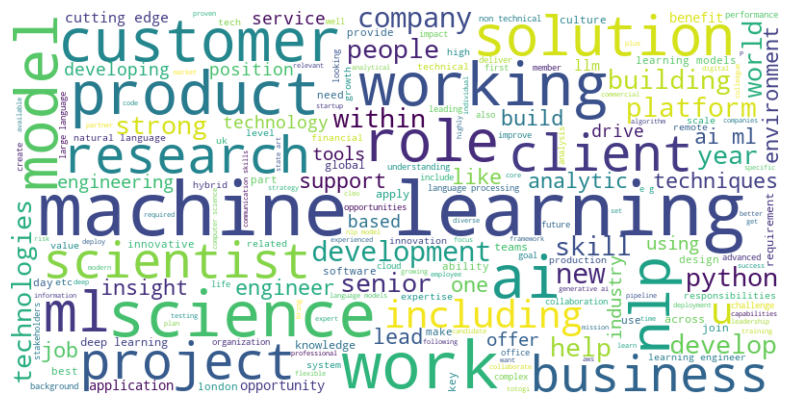

In [235]:
plot_word_cloud(labelled_jobs[labelled_jobs.submit_cv==1]['clean_description'], stopwords=['Experience','team','data'])

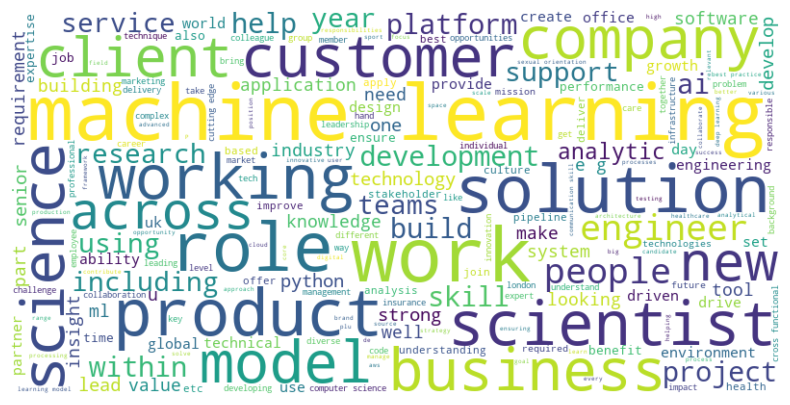

In [236]:
plot_word_cloud(labelled_jobs[labelled_jobs.submit_cv==0]['clean_description'], stopwords=['Experience','team','data'])

NLP and AI are more prominent in the positive class

## Zero shot classification I will try to see what is the area of each JD

In [250]:
from transformers import pipeline
pipe = pipeline(model="facebook/bart-large-mnli")
categories = ["Computer Vision, CV", "Natural Language Processing, Large Language Models, NLP, LLM", "Financial Tech, FinTech", "Other"]

results actually make sense

In [251]:
text = labelled_jobs.loc[2,'Description']
res = pipe(text, candidate_labels=categories)

In [252]:
print(res['sequence'])
print()
for k, v in zip(res['labels'], res['scores']):
    print(k,v)

The companyNebius AI is an AI-centric public cloud platform specifically crafted to serve AI models for training and inference.Our mission is to help ML practitioners concentrate on their core jobs, while DevOps, MLOps, and infrastructure-related tasks are handled by us. The idea is to build an ML-specific cloud platform covering the entire ML lifecycle from A to Z: from data preparation and labeling to ML training and inference.We recognize the potential of ML and AI technologies and aim to provide our future users with the perfect environment to train and fine-tune their models. We are committed to delivering the best user experience and excellent customer support.
Four development hubs:Nebius is headquartered in the Netherlands, with hubs in Finland, Serbia, and Israel.
Data center in Europe:Our own data center in Finland features server racks designed in-house for ML-specific high load, with power-efficient solutions, including a free-cooling system.
500+ professionals:Our mature t

## sklearn classifier

This training excercise is just to should case how I would do it for a supervised model, I have only annotated 200 samples so probably not enought to train a stable model

In [255]:
labelled_jobs[['Description','clean_description']].head(1)

,Description,clean_description
0,"We’re Kingfisher, A team made up of over 82,000 passionate people who bring Kingfisher - and all our other brands: B&Q, Screwfix, Brico Depot, Castorama and Koctas - to life. That’s right, we’re big, but we have ambitions to become even bigger and even better. We want to become the leading home improvement company and grow the largest community of home improvers in the world. And that’s where you come in.\n\nAt Kingfisher our customers come from all walks of life , and so do we. We want to ensure that all colleagues, future colleagues, and applicants to Kingfisher are treated equally regardless of age, gender, marital or civil partnership status, colour, ethnic or national origin, culture, religious belief, philosophical belief, political opinion, disability, gender identity, gender expression or sexual orientation.\n\nWe are open to flexible and agile working, both of hours and location. Therefore, we offer colleagues a blend of working from home and our offices, located in London, Southampton & Yeovil. Talk to us about how we can best support you !\n\nWe are looking for a Senior Machine Learning Engineer to join our growing team, to develop and deploy core ML/AI algorithms required to tackle data science challenges across Kingfisher Group. You will support data science projects from start to production, developing quality code and carrying out automated build and deployments, working closely with colleagues in the Data Science team as well as stakeholders across the business .\n\n What's the job? \n\n Develop high-quality machine learning models to solve business challenges Develop production quality code and carry out basic automated builds and deployments Write comprehensive, well written documentation that meets our needs Identify work and dependencies, track ing progress through a set of tasks Communicate clearly with colleagues and business stakeholders Proactively share ideas with colleagues and accept suggestions Ability to work on multiple data science projects and manage deliverables \n\nWhat You'll Bring\n\n Solid understanding of computer science fundamentals, including data structures, algorithms, data modelling and software architecture Solid understanding of classical Machine Learning algorithms ( e.g. Logistic Regression, Random Forest, XGBoost , etc) , state-of-the-art research area ( e.g. NLP, Transfer Learning etc) and modern Deep Learning algorithms ( e.g. BERT, LSTM, etc) Solid knowledge of SQL and Python's ecosystem for data analysis ( Jupyter , Pandas, Scikit Learn, Matplotlib, etc) Understanding of model evaluation, data pre-processing techniques, such as standardisation, normalisation, and handling missing data Solid understanding of summary, robust, and nonparametric statistics; hypothesis testing, probability distributions, sampling techniques, and stochastic processes \n\nAt Kingfisher, we value the perspectives that any new team members bring, and we want to hear from you. We encourage you to apply for one of our roles even if you do not feel you meet 100% of the requirements.\n\nIn return, we offer an inclusive environment, where what you can achieve is limited only by your imagination! We encourage new ideas , actively support experimentation, and strive to build an environment where everyone can be their best self.\n\nWe also offer a competitive benefits package and plenty of opportunities to stretch and grow your career.\n\nInterested? Great, apply now and help us to Power the Possible.\n\n",kingfisher team made passionate people bring kingfisher brands b q screwfix brico depot castorama koctas life right big ambitions become even bigger even better want become leading home improvement company grow largest community home improvers world come kingfisher customers come walks life want ensure colleagues future colleagues applicants kingfisher treated equally regardless age gender marital civil partnership status colour ethnic national origin culture religious bel

small sample so I don't expect much - lets start with a simple sklearn classification

In [262]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

#custom transformer here to do sentence embeddings
class WordEmbedder(BaseEstimator, TransformerMixin):
    '''selects range of columns from pandas dataframe'''
    def __init__(self, columns, model):
        self.columns = columns
        self.model = model
        
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            texts = X[self.columns].tolist()
        else:
            texts = X.tolist()
        #create average vector with the model provided
        texts_token = [sent_tokenize(t) for t in texts]
        vect = np.vstack([np.mean(self.model.encode(tt), axis=0) for tt in texts_token])
        return vect
    
    def fit(self, X, *_):
        return self


def set_pipeline(clf):    
    tfidf_transformer = Pipeline([
                            ('cv', CountVectorizer()),
                            ('tfidf', TfidfTransformer(use_idf=False, norm='l2'))])
    we_transformer = Pipeline([('we', WordEmbedder('extracted_skill', SentenceTransformer('paraphrase-MiniLM-L6-v2')))])
    preprocessor = ColumnTransformer(transformers = 
                                      [('description_tfidf', tfidf_transformer, 'clean_description'),
                                      ('skills_tfidf', tfidf_transformer, 'extracted_skills'),
                                      ('skills_embeddings', we_transformer, 'extracted_skills')])
    
    pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                            ('feature_select', SelectKBest()),
                            ('clf', clf)])
    return pipe1

In [258]:
ddf = pd.DataFrame([])
ddf['my_text'] = ['Today was a very long day. I went for shopping and then went beack home',
                   'Today was a very short day. I went for food and then went beack home']
we_transformer = Pipeline([('we', WordEmbedder('my_text', SentenceTransformer('paraphrase-MiniLM-L6-v2')))])
sample = we_transformer.fit_transform(ddf)

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

I will start with the random forest here that usually works well for the hight dimentional and sparse text data, I could tr others and compare but out of scope

In [267]:
clf = RandomForestClassifier(random_state=42)
pipe = set_pipeline(clf)
X_ref = labelled_jobs
y_ref = labelled_jobs.submit_cv

In [271]:
y_pred = cross_val_predict(pipe, X_ref, y_ref, cv=4)
print("classification report:")
print(classification_report(y_ref, y_pred))

classification report:
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       148
         1.0       0.79      0.66      0.72        50

    accuracy                           0.87       198
   macro avg       0.84      0.80      0.82       198
weighted avg       0.86      0.87      0.86       198



Not bad relative to amount of data and how much effort I spent to write this...
Let's apply my classifier to unseen data and see if I can dig new opportunities for myself

In [282]:
data_path ='/Users/yuliagoryachev/learning/langchain_course/llms/data/data_holdout/'
from utils.openai_parsings import get_salary_and_skills
def prepare_data_for_prediction(data_path: str):
    loader = Loader(data_path)
    df_hold_out = loader.load_csv()
    salary, skills = [], []
    for i in tqdm(df_hold_out.Description):
        try:
            keep = json.loads(get_salary_and_skills(i))
            salary.append(keep['salary'])
            skills.append(keep['skills'])
        except Exception as e:
            print(e)
            salary.append('none')
            skills.append([])
    df_hold_out['extracted_salary'] = salary
    df_hold_out['extracted_skills'] = skills
    df_hold_out['clean_description'] = df_hold_out.Description.apply(lambda x: cleaner.clean(x))
    return df_hold_out

In [283]:
df_holdout = prepare_data_for_prediction(data_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.44s/it]


In [292]:
df_holdout['extracted_skills'] = df_holdout.extracted_skills.apply(lambda x: str(x))

In [305]:
df_holdout_test = df_holdout[~df_holdout['Detail URL'].isin(labelled_jobs['Detail URL'])]

In [309]:
print(f'pre: {df_holdout.shape}, post: {df_holdout_test.shape}')

pre: (20, 17), post: (7, 17)


In [ ]:
fitted_pipe = pipe.fit(X_ref, y_ref)

In [312]:
y_test = fitted_pipe.predict_proba(df_holdout_test)
df_holdout_test = df_holdout_test.reset_index(drop=True)

In [313]:
print(df_holdout_test.loc[np.argmax(y_test[:,1])]['Description'], df_holdout_test.loc[np.argmax(y_test[:,1])]['Detail URL'])

At The Stepstone Group, we help everyone get the job that best fits their life. Whether it is the next step in their career, or a job to pay the bills - we exist to match lifestyles with livelihoods. We play our part by giving people everything they need to find the right job for them in that moment; making jobs work for more people, whatever they do, and however they choose to do it. Equal opportunities are important to us. We believe that diversity and inclusion at The Stepstone Group is critical to our success as a global company, so we want to recruit, develop, and keep the best talent on the market. We encourage applications from everyone, regardless of your background, gender identity, sexual orientation, disability status, ethnicity, belief, age, family or parental status, and any other characteristic. If you require reasonable accommodation in completing this application or interviewing, please let us know. 
We also have a hybrid approach to working from home and in the office!

In [314]:
print(df_holdout_test.loc[np.argmin(y_test[:,1])]['Description'], df_holdout_test.loc[np.argmin(y_test[:,1])]['Detail URL'])

Job Description

Data Modeler

UST is a leading provider of platforms, digital innovation, artificial Intelligence and end-to-end IT & Business services and solutions for Global 1000 companies. We are transforming corporations through deep domain expertise, knowledge-based ML platforms, as well as profound anthropological efforts to understand the end customer and design products and interactions that create delight. We are deeply committed to developing a comprehensive understanding of our clients problems and to develop platforms to address them.

Job Overview

We are seeking a skilled and detail-oriented Data Modeler to join our dynamic team in London. The ideal candidate will play a pivotal role in designing, implementing, and optimizing data structures to support our organization's data needs. The Data Modeler will collaborate with cross-functional teams to ensure effective communication between business requirements and technical implementations, promoting data integrity, securit

Yes, the first one is something that I would like to consider and the last one is less relevant

----------

## same features but with a neural network

In [7]:
labelled_jobs = pd.read_csv('~/Downloads/all_linkedin_roles_annotated_1.csv')

In [10]:
cleaner = Cleaner(stopwords=stopwords, tokenizer=RegexpTokenizer(r'\w+'), lang='english', stop=True)
labelled_jobs['clean_description'] = labelled_jobs.Description.apply(lambda x: cleaner.clean(x))

Data preparation

In [11]:
from transformers import AutoTokenizer
import torch
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
from typing import List
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split

# Load the DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
distilbert_model = AutoModel.from_pretrained(model_name)

In [12]:
def tokenize_text(texts: List[str], labels: List[int]):
    # Tokenize and encode text data
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    
    # Convert labels to tensors
    labels = torch.tensor(labels)
    return input_ids, attention_mask, labels

In [65]:
labelled_jobs = labelled_jobs.dropna(subset=['submit_cv'])

In [66]:
labelled_jobs['submit_cv'] = labelled_jobs.submit_cv.astype(int)

In [67]:
train, val = train_test_split(labelled_jobs, test_size=0.3, random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [68]:
# For now I will use the description as my training text, 
# I do not clean the Description data because the transformer can deal with the upper case letter the noisy tokens and the stopwords
# unlike the tfidf, I could try and use the cleaned text and see the effect of that
train_input_ids, train_attention_mask, train_labels = tokenize_text(train.Description.tolist(), train.submit_cv)
val_input_ids, val_attention_mask, val_labels = tokenize_text(val.Description.tolist(), val.submit_cv)

In [71]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx],self.attention_mask[idx],self.labels[idx]

In [72]:
train_dataset = CustomDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = CustomDataset(val_input_ids, val_attention_mask, val_labels)

# Create DataLoader objects
batch_size = 16  # Adjust batch size as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

define the model

In [79]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Load the DistilBERT model as an embedding layer
        self.distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

        # Add more layers as needed for your specific task
        self.fc = nn.Linear(768, 1)  # 768 is the output dimension of DistilBERT
    
    def forward(self, input_ids, attention_mask):
        # Forward pass through DistilBERT model
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the output from DistilBERT as input for classification layers
        pooled_output = outputs['last_hidden_state']
        # Further processing or classification layers
        output = self.fc(pooled_output)
        return output


In [80]:
import torch

# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


Define the training loop

In [81]:
model = CustomModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader):  # Iterate over training batches
        input_ids, attention_mask, labels = batch
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels.reshape(-1,1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation (evaluate the model on the validation dataset)
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in val_dataloader:  # Iterate over validation batches
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'custom_model.pth')

eval
tensor([[[ 4.6815],
         [ 4.0970],
         [ 3.2469],
         ...,
         [-5.9550],
         [-5.9264],
         [-5.9054]],

        [[ 4.6788],
         [ 4.1367],
         [ 3.4629],
         ...,
         [-5.9306],
         [-5.9068],
         [-5.8803]],

        [[ 4.7124],
         [ 3.8495],
         [ 2.0797],
         ...,
         [-5.7947],
         [-5.7805],
         [-1.0778]],

        ...,

        [[ 4.6968],
         [ 4.0096],
         [ 3.0594],
         ...,
         [-5.9026],
         [-5.8699],
         [-5.8549]],

        [[ 4.4628],
         [ 4.1951],
         [ 3.5592],
         ...,
         [-5.8494],
         [-5.7878],
         [-1.2971]],

        [[ 4.1688],
         [ 2.5965],
         [ 0.2048],
         ...,
         [-5.3792],
         [-5.3564],
         [-5.3273]]])
eval
tensor([[[ 4.4836],
         [ 3.8058],
         [ 1.3801],
         ...,
         [-5.7750],
         [-5.7716],
         [-1.2484]],

        [[ 4.1823],
    

In [102]:
val_dataloader = DataLoader(val_dataset, batch_size=1)
all_preds = []
model.eval()
with torch.no_grad():
    # Validation loop
    for batch in tqdm(val_dataloader):
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs, dim=1)
        all_preds.append(predicted)
        # Calculate metrics (e.g., accuracy, F1 score) here

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:07<00:00,  7.95it/s]


In [110]:
ppreds = [int(i[0]) for i in all_preds]

In [114]:
print(classification_report(val_dataset.labels,ppreds))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85        48
           1       0.20      0.08      0.12        12

    accuracy                           0.75        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.68      0.75      0.71        60



## Question answering with my data

Despite taking the classification and recommendation approach to look for relevant roles, I want to be able to extract more specific information about the roles, this I can do with langchain Retrievers

In [58]:
from langchain.retrievers import BM25Retriever
from langchain.schema import Document

In [115]:
docs = [Document(page_content=desc, metadata={'url': url}) for desc, url in zip(csv_data.Description, csv_data['Detail URL'])]
retriever = BM25Retriever.from_documents(
    docs,
    k=100
)

In [117]:
result = retriever.get_relevant_documents("Finance, Fintech")
for i in result[:5]:
    print(i.metadata)

{'url': 'https://www.linkedin.com/jobs/view/3817005413/'}
{'url': 'https://www.linkedin.com/jobs/view/3765912230/'}
{'url': 'https://www.linkedin.com/jobs/view/3817343353/'}
{'url': 'https://www.linkedin.com/jobs/view/3806822007/'}
{'url': 'https://www.linkedin.com/jobs/view/3794007762/'}


In [118]:
result = retriever.get_relevant_documents("JPMorgan")
for i in result[:5]:
    print(i.metadata)

{'url': 'https://www.linkedin.com/jobs/view/3812092884/'}
{'url': 'https://www.linkedin.com/jobs/view/3804144400/'}
{'url': 'https://www.linkedin.com/jobs/view/3817320113/'}
{'url': 'https://www.linkedin.com/jobs/view/3794007762/'}
{'url': 'https://www.linkedin.com/jobs/view/3576159272/'}


In [119]:
result = retriever.get_relevant_documents("I would like to find NLP roles in JPMorgan")
for i in result[:5]:
    print(i.metadata)

{'url': 'https://www.linkedin.com/jobs/view/3789279665/'}
{'url': 'https://www.linkedin.com/jobs/view/3789277646/'}
{'url': 'https://www.linkedin.com/jobs/view/3792937160/'}
{'url': 'https://www.linkedin.com/jobs/view/3812092884/'}
{'url': 'https://www.linkedin.com/jobs/view/3797457300/'}


This kind of retriever is good for short phrases and concrete keywords, The JPMorgan NLP role is only the fourth and the only one in the list even thought we have 2 JPMorgan NLP roles in the dataset. Lets see how Cohere can help us.

# cohere retriever

The Cohere Rerank endpoint is designed to improve the result of index based search by adding semntic similarity to rerank the results. Moreover the claim their results are also better than just using semantic search alon, so the best of both worlds. This is not a free API, here is the link for more information https://txt.cohere.com/rerank/

In [128]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings import CohereEmbeddings
from langchain.retrievers.document_compressors import CohereRerank
from langchain.retrievers import ContextualCompressionRetriever
import cohere
from cohere import Client

In [129]:
from dotenv import load_dotenv, find_dotenv, dotenv_values

path_to_keys = '/Users/yuliagoryachev/learning/langchain_course/llms/keys.env'
temp = dotenv_values(path_to_keys)
cohere_api_key = temp["COHERE_API_KEY"]

In [130]:
#work around to fix a cohere error
class CustomCohereRerank(CohereRerank):
    class Config(CohereRerank.Config):
        arbitrary_types_allowed = True

CustomCohereRerank.update_forward_refs()
compressor=CustomCohereRerank(cohere_api_key=cohere_api_key,client=Client,top_n=100)

In [105]:
csv_data[csv_data['Company Name']=='JPMorgan Chase & Co.']

,Title,Description,Description HTML,Primary Description,Detail URL,Location,Skill,Insight,Job State,Poster Id,Company Name,Company Logo,Created At,Scraped At,Unnamed: 0.1,Unnamed: 0,extracted_skills,extracted_salary
3,Applied AI ML Lead - Senior Machine Learning E...,Job Description\n\nApplied AI ML at JPMorgan C...,<strong>Job Description\n\n</strong>Applied AI...,JPMorgan Chase & Co.,https://www.linkedin.com/jobs/view/3812092884/,"London, England, United Kingdom",6 of 10 skills match your profile - you may be...,"10,001+ employees · Financial Services\n1 comp...",LISTED,6077559,JPMorgan Chase & Co.,https://media.licdn.com/dms/image/C4E0BAQFN7ZG...,2024-01-27T04:12:14.000Z,2024-02-03T21:37:33.491Z,NaN,NaN,NaN,NaN
60,Senior Python ML Engineer - Applied AI ML Lead,Job Description\n\nWe have an opportunity to i...,<strong>Job Description\n\n</strong>We have an...,JPMorgan Chase & Co.,https://www.linkedin.com/jobs/view/3804144400/,"London, England, United Kingdom",NaN,"10,001+ employees · Financial Services\n1 comp...",LISTED,6077559,JPMorgan Chase & Co.,https://media.licdn.com/dms/image/C4E0BAQFN7ZG...,2024-01-17T22:07:23.000Z,2024-02-03T21:34:46.455Z,NaN,NaN,NaN,NaN


In [132]:
from langchain_community.llms import Cohere

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

compressed_docs = compression_retriever.get_relevant_documents(
    "I would like to find NLP roles in JPMorgan"
)

In [133]:
for i in compressed_docs[:10]:
    print(i)
    print()

page_content='Job Description\n\nApplied AI ML at JPMorgan Corporate Investment Bank combine cutting edge AI techniques with the company’s unique data assets to optimize business decisions and automate processes. In this role, you will be part of our industry-leading team, and advance the state-of-the-art in AI as applied to financial services. You will leverage the latest research from fields of Natural Language Processing, Computer Vision and statistical machine learning to build products that automate process, help experts prioritize their time and make better decisions.\n\nWe have a growing portfolio of AI–powered products and services and increasing opportunity for re-use of foundational components through careful design of libraries and services to be leveraged across the team.\n\nJob Responsibilities\n\nThis role straddles the boundary between Scientific Research and Software Engineering and requires a deep understanding of both mindsets. Our Machine Learning Engineers collabora

We have only 2 JPMorgan roles and both are NLP related, with the cohere retriever we were able to put both of them to the top

------------

Thats it for now